In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Connecting to my Postgres Database

In [4]:
# Postgres info to connect

connection_args = {
    'host': 'MY CURRENT AWS IP ADDRESS',  # My current AWS IP Address
    'dbname': 'voting',    # DB that we are connecting to
    'port': 5432,          # port on AWS
    'user': 'ubuntu'       #username
}

connection = pg.connect(**connection_args)

In [5]:
query = "SELECT * FROM bye LIMIT 5;"

pd_sql.read_sql(query, connection)

,user_id,yob,gender,income,householdstatus,educationlevel,party,q124742,q124122,q123464,...,q100010,q99716,q99581,q99480,q98869,q98578,q98059,q98078,q98197,q96024
0,1,1938,Male,None,Married (w/kids),None,Democrat,No,None,No,...,Yes,No,No,None,No,None,Only-child,No,No,Yes
1,4,1970,Female,"over $150,000",Domestic Partners (w/kids),Bachelor's Degree,Democrat,None,Yes,No,...,None,None,None,No,No,No,Only-child,Yes,No,No
2,5,1997,Male,"$75,000 - $100,000",Single (no kids),High School Diploma,Republican,None,Yes,Yes,...,Yes,No,No,No,Yes,No,Yes,No,Yes,No
3,8,1983,Male,"$100,001 - $150,000",Married (w/kids),Bachelor's Degree,Democrat,No,Yes,No,...,No,No,No,Yes,Yes,No,Yes,No,No,Yes
4,9,1984,Female,"$50,000 - $74,999",Married (w/kids),High School Diploma,Republican,No,Yes,No,...,Yes,No,No,Yes,No,No,Yes,No,No,Yes


**Yes it works! Alright let's grab just the traditional data (first 7 columns) and do some EDA**

In [47]:
query = "SELECT user_id,yob,gender,income,householdstatus,educationlevel,party FROM bye;"
df = pd_sql.read_sql(query, connection)

In [49]:
#minor data cleaning
df.yob = pd.to_numeric(df.yob, errors='coerce',downcast='integer')
df.yob.astype(int,errors='ignore')

0       1938.0
1       1970.0
2       1997.0
3       1983.0
4       1984.0
         ...  
5563    1945.0
5564    1970.0
5565       NaN
5566    1966.0
5567       NaN
Name: yob, Length: 5568, dtype: float64

In [50]:
#more data cleaning
df.user_id = df.user_id.astype(int,errors='ignore')

In [51]:
df.dtypes

user_id              int64
yob                float64
gender              object
income              object
householdstatus     object
educationlevel      object
party               object
dtype: object

In [112]:
#making dummy variables
dummy_df = pd.get_dummies(df, columns=['gender','income','householdstatus','educationlevel'])

In [121]:
dummy_df

,user_id,yob,party,gender_Female,gender_Male,"income_$100,001 - $150,000","income_$25,001 - $50,000","income_$50,000 - $74,999","income_$75,000 - $100,000","income_over $150,000",...,householdstatus_Single (no kids),householdstatus_Single (w/kids),educationlevel_Associate's Degree,educationlevel_Bachelor's Degree,educationlevel_Current K-12,educationlevel_Current Undergraduate,educationlevel_Doctoral Degree,educationlevel_High School Diploma,educationlevel_Master's Degree,target
0,1,1938.0,Democrat,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,1970.0,Democrat,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,5,1997.0,Republican,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,8,1983.0,Democrat,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,9,1984.0,Republican,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,6952,1945.0,Democrat,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5564,6953,1970.0,Democrat,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5565,6954,NaN,Democrat,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
5566,6955,1966.0,Democrat,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


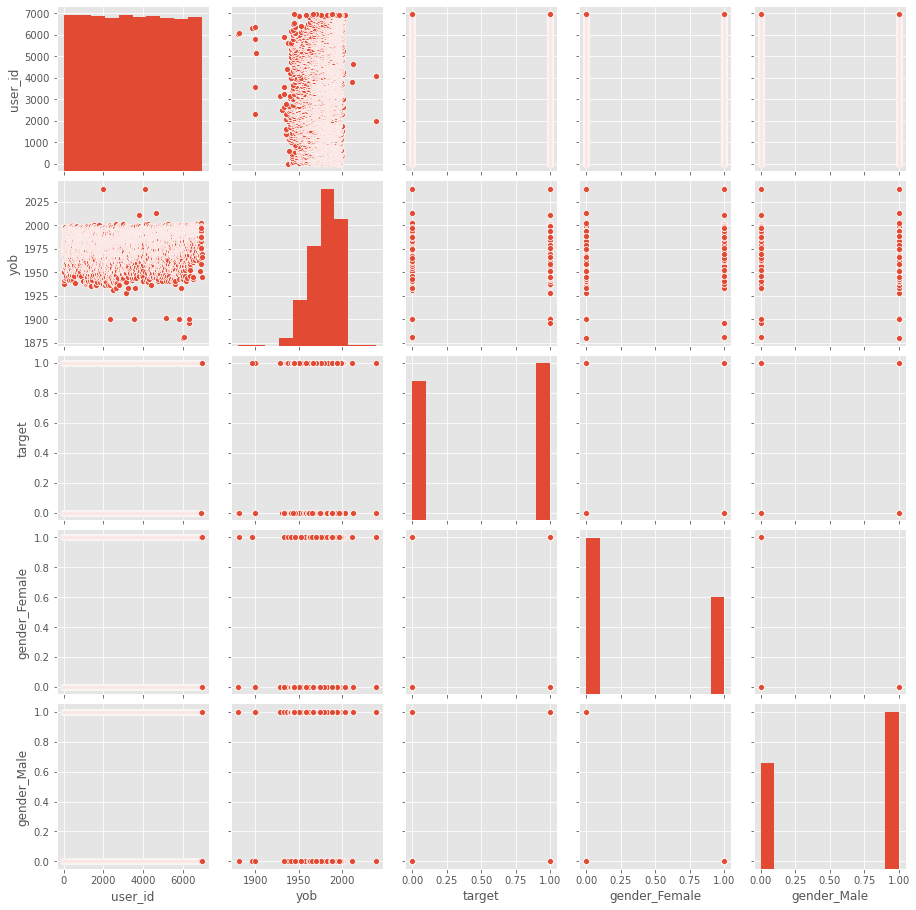

In [122]:
sns.pairplot(dummy_df[['user_id','yob', 'target', 'gender_Female', 'gender_Male']])

Pairplot didn't help. Let's write a function to view bar charts showing the distribution of voting for each feature

In [252]:
def plot_feature(df,column):
    """
    Purpose: Show distribution of voting between republicans and democrats for the feature inputed
    Arguments: dataframe with the features and column name
    Returns: Bar plot for distribution for the particular feature, and percentage split between two groups
    """
    mask = df[column] == 1
    
    #assigning variables 
    if df[mask].party.value_counts().index[0] == 'Democrat':
        amount_dem = df[mask].party.value_counts()[0]
        amount_rep = df[mask].party.value_counts()[1]
    else:
        amount_dem = df[mask].party.value_counts()[1]
        amount_rep = df[mask].party.value_counts()[0]
    
    #plotting the bar graph
    plt.bar(['Democrat','Republican'], [amount_dem,amount_rep])
    
    #printing the percentages of republicans and democrats in this group
    print('Democrats: ' + str(100*(amount_dem/(amount_dem+amount_rep))))
    print('Republicans: ' + str(100*(amount_rep/(amount_dem+amount_rep))))
    
    return df[mask].party.value_counts()

## Gender

Male

Democrats: 48.51127819548872
Republicans: 51.48872180451127


Republican    1712
Democrat      1613
Name: party, dtype: int64

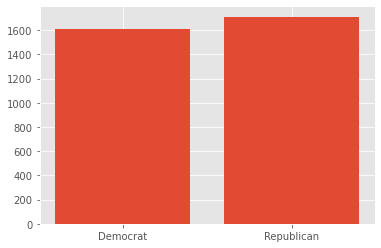

In [253]:
plot_feature(dummy_df,'gender_Male')

Female

Democrats: 59.859154929577464
Republicans: 40.140845070422536


Democrat      1275
Republican     855
Name: party, dtype: int64

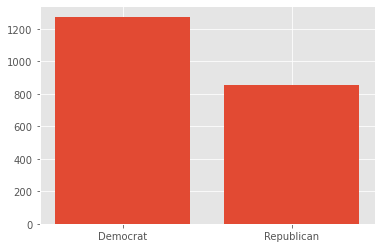

In [254]:
plot_feature(dummy_df,'gender_Female')

**First insight: Males in this sample tend to pretty evenly split but Females are more likely to vote Democrat**

## YOB

In [164]:
#ok so the median yob is 1983 so I'll cut the data in half 
dummy_df.yob.median()

1983.0

<BarContainer object of 2 artists>

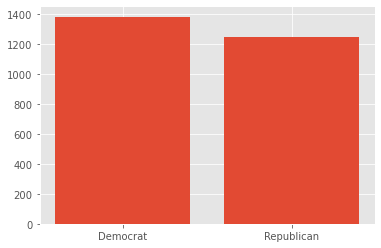

In [174]:
median_yob = dummy_df.yob.median()
#dummy_df[dummy_df.yob >= median_yob].party.value_counts()

#For people born on or after 1983 here is the distribution between republican and democrat
plt.bar(['Democrat','Republican'],dummy_df[dummy_df.yob >= median_yob].party.value_counts())

<BarContainer object of 2 artists>

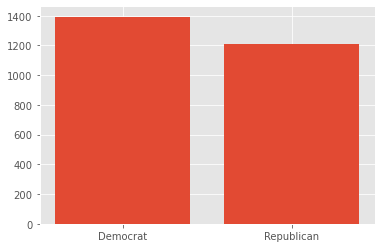

In [175]:
#For people born before 1983 here is the distribution between republican and democrat
plt.bar(['Democrat','Republican'],dummy_df[dummy_df.yob < median_yob].party.value_counts())

**Both groups lean democrat slightly. Let's push the split year back and see what happens**

### 18-34 year olds

Democrat      1243
Republican    1100
Name: party, dtype: int64

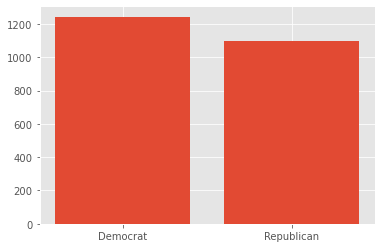

In [187]:
#For 18-34 year olds here is the distribution between republican and democrat
mask = (dummy_df.yob <= 1995) & (dummy_df.yob >= 1979)
plt.bar(['Democrat','Republican'],dummy_df[mask].party.value_counts())
dummy_df[mask].party.value_counts()

### 35-55 year olds

Democrat      835
Republican    741
Name: party, dtype: int64

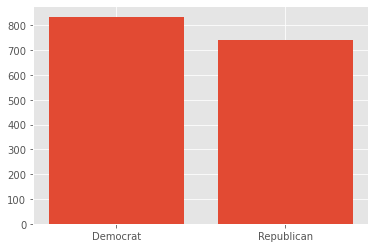

In [188]:
#For people 35-55 years old here is the distribution between republican and democrat
mask = (dummy_df.yob < 1979) & (dummy_df.yob >= 1958)
plt.bar(['Democrat','Republican'],dummy_df[mask].party.value_counts())
dummy_df[mask].party.value_counts()

### 55+

Democrat      310
Republican    238
Name: party, dtype: int64

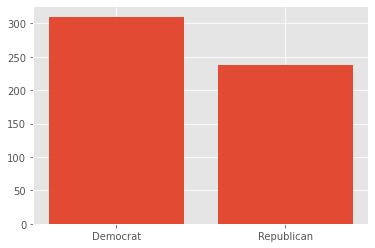

In [189]:
#For people over 55 years old here is the distribution between republican and democrat
mask = (dummy_df.yob < 1958)
plt.bar(['Democrat','Republican'],dummy_df[mask].party.value_counts())
dummy_df[mask].party.value_counts()

**Ok so no real difference in age**

In [183]:
#saving this df
dummy_df.to_pickle("dummy_df.pkl")

## Income Level

### Under $25k 

Democrats: 53.954802259887
Republicans: 46.04519774011299


(Democrat      382
 Republican    326
 Name: party, dtype: int64,)

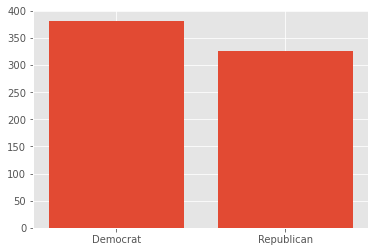

In [223]:
#showing the distribution of voting for the income level: 25,001 - $50,000
plot_feature(dummy_df,'income_under $25,000')

### $25k to 50k

Democrats: 53.954802259887
Republicans: 46.04519774011299


(Democrat      382
 Republican    326
 Name: party, dtype: int64,)

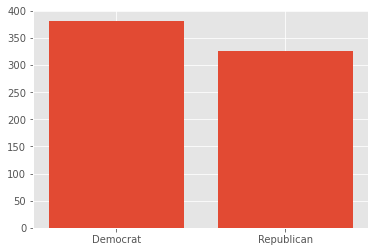

In [230]:
#showing the distribution of voting for the income level: 25,001 - $50,000
plot_feature(dummy_df,'income_$25,001 - $50,000')

### $50k to 75k

Democrats: 53.66748166259169
Republicans: 46.33251833740831


(Democrat      439
 Republican    379
 Name: party, dtype: int64,)

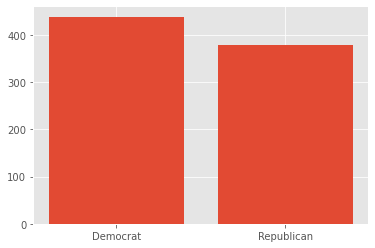

In [226]:
#showing the distribution of voting for the income level: $50,000 - $74,999
plot_feature(dummy_df,'income_$50,000 - $74,999')

### $100k to 150k

Democrats: 53.255208333333336
Republicans: 46.74479166666667


(Democrat      409
 Republican    359
 Name: party, dtype: int64,)

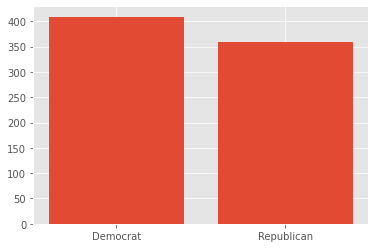

In [228]:
#showing the distribution of voting for the income level: $100,001 - $150,000
plot_feature(dummy_df,'income_$100,001 - $150,000')

### $150k+

Democrats: 48.1029810298103
Republicans: 51.8970189701897


(Republican    383
 Democrat      355
 Name: party, dtype: int64,)

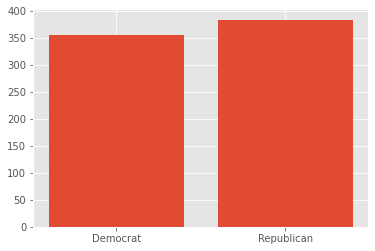

In [229]:
#showing the distribution of voting for the income level: over $150,000
plot_feature(dummy_df,'income_over $150,000')

## Marital Status

### Domestic Partners (no kids):

Democrats: 72.77777777777777
Republicans: 27.22222222222222


(Democrat      131
 Republican     49
 Name: party, dtype: int64,)

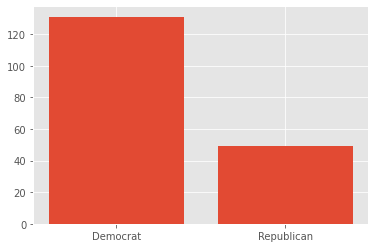

In [232]:
plot_feature(dummy_df,'householdstatus_Domestic Partners (no kids)')

### Domestic Partners w/kids

Democrats: 57.377049180327866
Republicans: 42.62295081967213


(Democrat      35
 Republican    26
 Name: party, dtype: int64,)

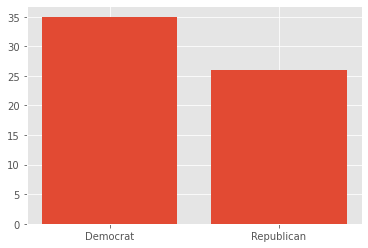

In [234]:
plot_feature(dummy_df,'householdstatus_Domestic Partners (w/kids)')

### Married no kids

Democrats: 52.760736196319016
Republicans: 47.239263803680984


(Democrat      344
 Republican    308
 Name: party, dtype: int64,)

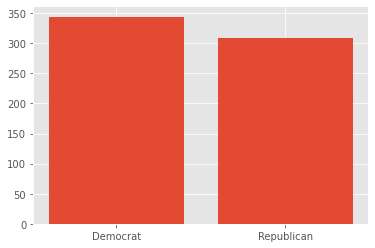

In [235]:
plot_feature(dummy_df,'householdstatus_Married (no kids)')

### Married with kids

Democrats: 47.17691342534505
Republicans: 52.82308657465495


(Republican    842
 Democrat      752
 Name: party, dtype: int64,)

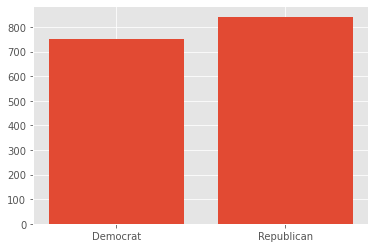

In [237]:
plot_feature(dummy_df,'householdstatus_Married (w/kids)')

### Single no kids

Democrats: 55.121349238996295
Republicans: 44.878650761003705


(Democrat      1340
 Republican    1091
 Name: party, dtype: int64,)

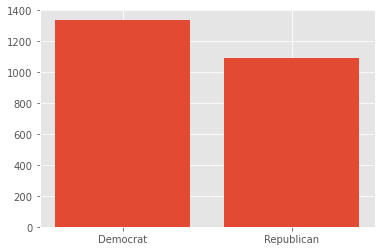

In [238]:
plot_feature(dummy_df,'householdstatus_Single (no kids)')

### Single with kids

Democrats: 59.5
Republicans: 40.5


(Democrat      119
 Republican     81
 Name: party, dtype: int64,)

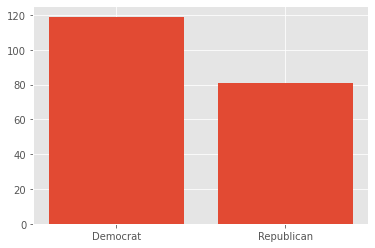

In [239]:
plot_feature(dummy_df,'householdstatus_Single (w/kids)')

## Education

### Associates Degree

Democrats: 46.8421052631579
Republicans: 53.1578947368421


(Republican    202
 Democrat      178
 Name: party, dtype: int64,)

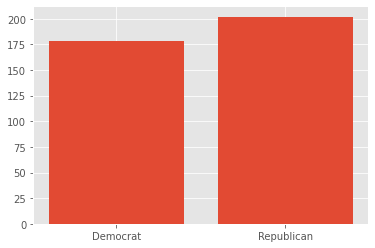

In [242]:
plot_feature(dummy_df,"educationlevel_Associate's Degree")

### Bachelor's Degree

Democrats: 54.72636815920397
Republicans: 45.27363184079602


(Democrat      660
 Republican    546
 Name: party, dtype: int64,)

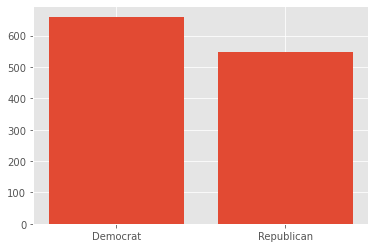

In [243]:
plot_feature(dummy_df,"educationlevel_Bachelor's Degree")

### Current K-12

Democrats: 51.86522262334536
Republicans: 48.13477737665463


(Democrat      431
 Republican    400
 Name: party, dtype: int64,)

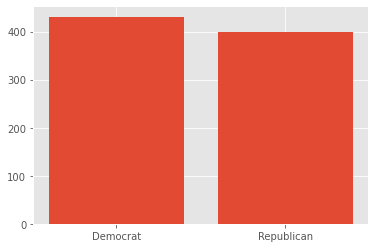

In [244]:
plot_feature(dummy_df,"educationlevel_Current K-12")

### Current Undergrad

Democrats: 54.88917861799217
Republicans: 45.11082138200782


(Democrat      421
 Republican    346
 Name: party, dtype: int64,)

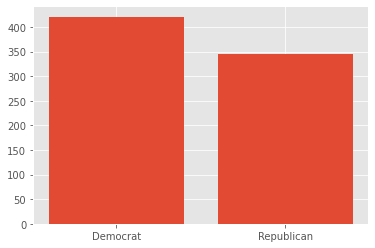

In [245]:
plot_feature(dummy_df,"educationlevel_Current Undergraduate")

### Doctoral Degree

Democrats: 55.05050505050505
Republicans: 44.94949494949495


(Democrat      109
 Republican     89
 Name: party, dtype: int64,)

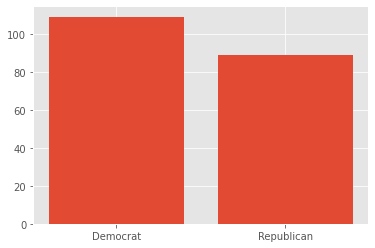

In [246]:
plot_feature(dummy_df,'educationlevel_Doctoral Degree')

### High School Diploma

Democrats: 50.51395007342144
Republicans: 49.48604992657856


(Democrat      344
 Republican    337
 Name: party, dtype: int64,)

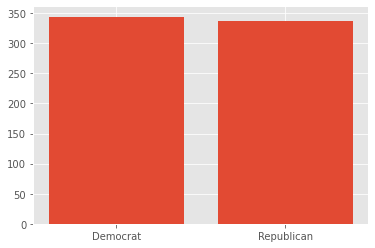

In [247]:
plot_feature(dummy_df,'educationlevel_High School Diploma')

### Master's Degree

Democrats: 57.58998435054773
Republicans: 42.41001564945227


(Democrat      368
 Republican    271
 Name: party, dtype: int64,)

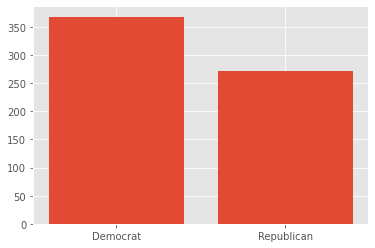

In [249]:
plot_feature(dummy_df,"educationlevel_Master's Degree")

**Features with 60% or greater split**

1. Domestic Partners no kids (dem)
1. Single with kids (dem)
1. Female_gender (dem)

**Some more basic visualizations down here:**

In [44]:
def plot_dem_versus_rep(df):
    """
    Purpose: Show distribution of voting between republians and democrats for the whole dataset
    Arguments: dataframe with voters and a column named 'Party' containing the party they intend to vote for
    Returns: Bar plot showing how many people say they are voting either rep or dem
    """
    
    
    #assigning variables 
    if df.Party.value_counts().index[0] == 'Democrat':
        amount_dem = df.Party.value_counts()[0]
        amount_rep = df.Party.value_counts()[1]
    else:
        amount_dem = df.Party.value_counts()[1]
        amount_rep = df.Party.value_counts()[0]
    
    #plotting the bar graph
    plt.figure(figsize=(12,8))
    barlist = plt.bar(['Democrat','Republican'], [amount_dem,amount_rep])
    barlist[0].set_color('b')
    barlist[1].set_color('r')
    plt.xticks(fontsize=15, color='black')
    plt.yticks(fontsize=10, color='black')
    plt.ylabel('Amount', fontsize=15, rotation='horizontal', horizontalalignment='right', color='black')
    ax = plt.axes()        
    ax.xaxis.grid(False) 
    
    plt.savefig('Total_dems_vs_reps.png',format='png',bbox_inches='tight')
    
    #printing the percentages of republicans and democrats in this group
    print('Democrats: ' + str(100*(amount_dem/(amount_dem+amount_rep))))
    print('Republicans: ' + str(100*(amount_rep/(amount_dem+amount_rep))))
    
    return df.Party.value_counts()

Democrats: 52.99928160919541
Republicans: 47.00071839080459


/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Democrat      2951
Republican    2617
Name: Party, dtype: int64

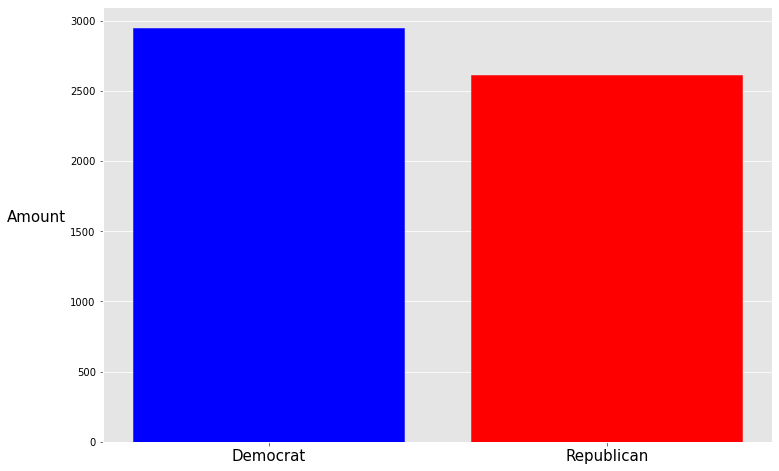

In [45]:
plot_dem_versus_rep(df)